In [1]:
# --- Import libraries --- #
import pandas as pd
import numpy as np
from patsy import dmatrices, dmatrix
from scipy import stats
from scipy.special import expit as logistic
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import seaborn as sns

import theano
import theano.tensor as tt
import pymc3 as pm
import arviz as az

import warnings
warnings.simplefilter(action="ignore")
%config InlineBackend.figure_format = 'retina'

print("Packages uploaded successfully!")

Packages uploaded successfully!


In [2]:
# --- Read data --- #
data = pd.read_csv('./machine_readable.csv')

# --- Standardise continuous values --- #
data_prep = data[['LogD', 'Cbrain/Cblood','Syn_EC30', 
                  'Viability_EC30', 'NNF_EC50min', 'NNF_EC50max', 'Viability_LDH_EC50', 'Viability_AB_EC50']]
sc = StandardScaler()
data_scaled = sc.fit_transform(data_prep)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['LogD', 'Cbrain/Cblood','Syn_EC30', 
                       'Viability_EC30', 'NNF_EC50min', 'NNF_EC50max', 'Viability_LDH_EC50', 'Viability_AB_EC50']

# Add other discrete values and details
discrete = data [['Chemical', 'CASRN', 'DNT', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 
  'BDNF_Reduction', 'Activity_Syn', 'Activity_NNF']]
data = discrete.join(data_scaled, lsuffix="_left", rsuffix="_right")

# --- Define predictors and outcomes --- #

# BDNF given by continuous and discrete variables
x_bdnf = pd.DataFrame(data[['LogD', 'Cbrain/Cblood', 'BBB', 
                            'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active']]).values
y_bdnf = pd.DataFrame(data[['BDNF_Reduction']]).values

# SYN
x_syn = pd.DataFrame(data[['Syn_EC30', 'Viability_EC30']]).values
Y_syn = pd.DataFrame(data[['Activity_Syn']]).values #Y because no missing values

# NNF
x_nnf = pd.DataFrame(data[['NNF_EC50min', 'NNF_EC50max', 'Viability_LDH_EC50', 'Viability_AB_EC50']]).values
Y_nnf = pd.DataFrame(data[['Activity_NNF']]).values #Y because no missing values

# x_dnt is given by causal relations BDNF->SYN->NNF->DNT<-BNDF
Y_dnt = pd.DataFrame(data[['DNT']]).values #Y because no missing values

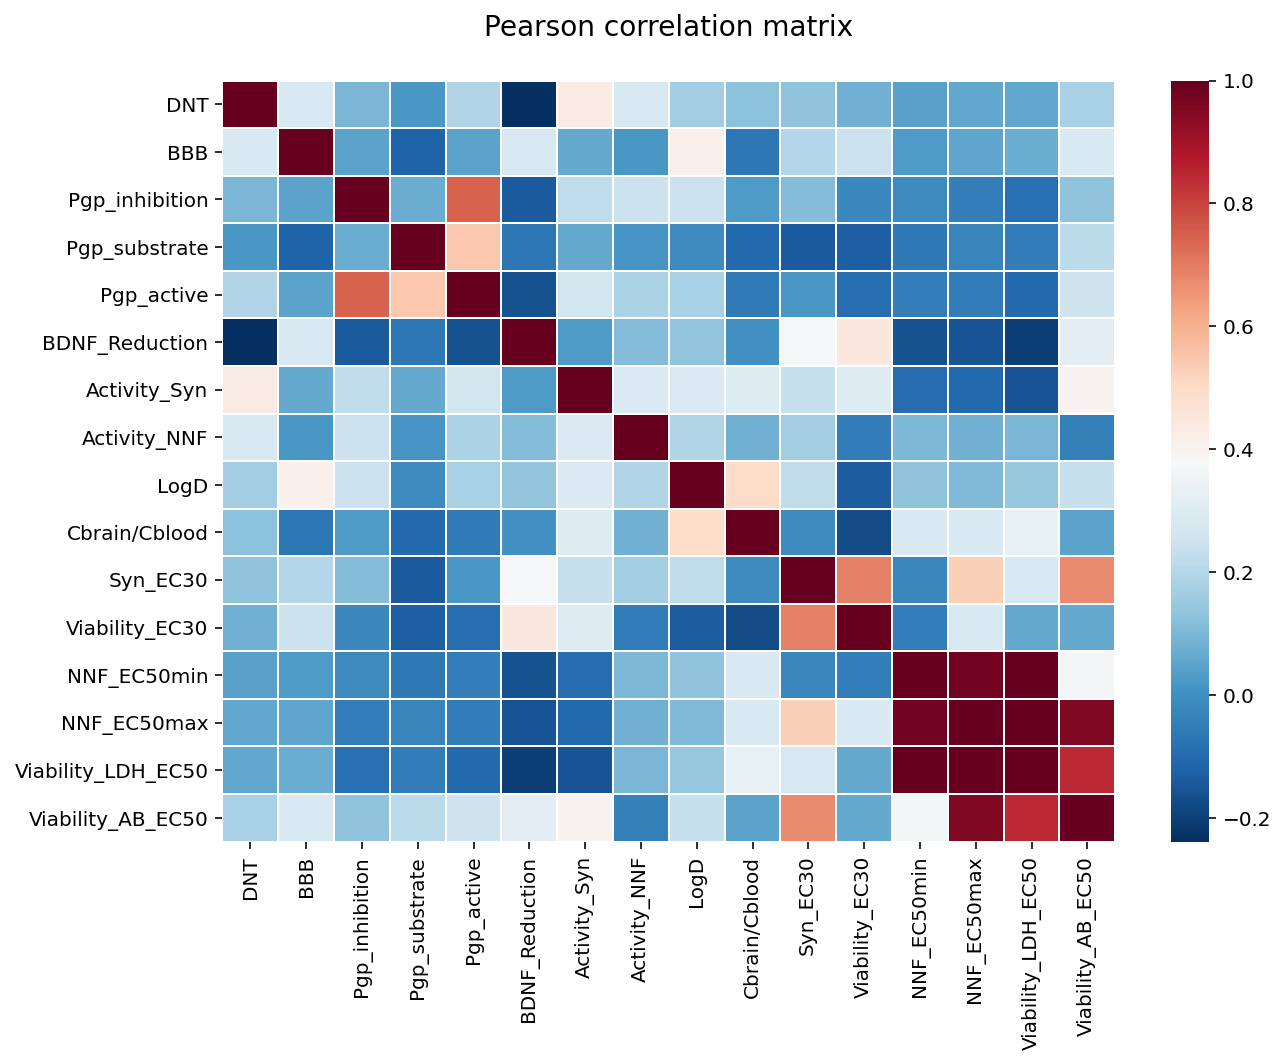

In [3]:
# Variables high correlated but not with the target variable - prediction of DNT, Activity NNF/SYN/BDNF
fig, ax = plt.subplots(figsize=(10,7))
pearsoncorr = data.corr(method='pearson')
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=False,
            linewidth=0.5)
plt.title("Pearson correlation matrix\n", fontsize = 14);

In [4]:
# --- Masking missing data --- #
# BDNF
x_bdnf_missing = np.isnan(x_bdnf)
X_bdnf_train = np.ma.masked_array(x_bdnf, mask=x_bdnf_missing)
y_bdnf_missing = np.isnan(y_bdnf)
Y_bdnf_train = np.ma.masked_array(y_bdnf, mask=y_bdnf_missing)

# SYN
x_syn_missing = np.isnan(x_syn)
X_syn_train = np.ma.masked_array(x_syn, mask=x_syn_missing)

# NNF
x_nnf_missing = np.isnan(x_nnf)
X_nnf_train = np.ma.masked_array(x_nnf, mask=x_nnf_missing)

In [5]:
# --- Define and fit the model --- #
with pm.Model() as model1:
    # Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.001) 
    sd_beta = pm.HalfNormal('sd_beta', sd=1)
    # Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(4,1))
    
    # Imputation of X missing values for BDNF
    Xmu_bdnf = pm.Normal('Xmu_bdnf', mu=0, sd=0.001, shape=(1,6))
    Xsigma_bdnf = pm.HalfNormal('Xsigma_bdnf', sd=1, shape=(1,6))
    X_bdnf_modelled = pm.Normal('X_bdnf_modelled', 
                                         mu=Xmu_bdnf, sigma=Xsigma_bdnf, observed=X_bdnf_train)

    # Likelihood for BDNF
    # SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', pm.math.dot(X_bdnf_modelled, beta_bdnf))
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=Y_bdnf_train)
    
    # Imputation of X missing values for SYN
    Xmu_syn = pm.Normal('Xmu_syn', mu=0, sd=0.001, shape=(1,2))
    Xsigma_syn = pm.HalfNormal('Xsigma_syn', sd=1, shape=(1,2))
    X_syn_modelled = pm.Normal('X_syn_modelled',
                                 mu=Xmu_syn, sigma=Xsigma_syn, observed=X_syn_train)

    # Likelihood for SYN
    # BDNF->SYN
    lp_syn = pm.Deterministic('lp_syn', lp_bdnf + pm.math.dot(X_syn_modelled, beta_syn))
    y_obs_syn = pm.Bernoulli("y_obs_syn", logit_p=lp_syn, observed=Y_syn)
    
    # Imputation of X missing values for NNF
    Xmu_nnf = pm.Normal('Xmu_nnf', mu=0, sd=0.001, shape=(1,4))
    Xsigma_nnf = pm.HalfNormal('Xsigma_nnf', sd=1, shape=(1,4)) 
    X_nnf_modelled = pm.Normal('X_nnf_modelled',
                                 mu=Xmu_nnf, sd=Xsigma_nnf, observed=X_nnf_train)
   
    # Likelihood for NNF
    # BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', lp_syn + pm.math.dot(X_nnf_modelled, beta_nnf))
    y_obs_nnf = pm.Bernoulli("y_obs_nnf", logit_p=lp_nnf, observed=Y_nnf)
    
    # Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt)

# Checking the proposed structure of model
model1.check_test_point()

mu_beta                      5.99
sd_beta_log__               -0.77
beta_bdnf                   -4.16
beta_syn                    -1.39
beta_nnf                    -2.77
Xmu_bdnf                    35.93
Xsigma_bdnf_log__           -4.62
X_bdnf_modelled_missing      0.00
y_obs_bdnf_missing           0.00
Xmu_syn                     11.98
Xsigma_syn_log__            -1.54
X_syn_modelled_missing       0.00
Xmu_nnf                     23.96
Xsigma_nnf_log__            -3.08
X_nnf_modelled_missing       0.00
X_bdnf_modelled           -552.12
y_obs_bdnf                 -61.00
X_syn_modelled            -172.26
y_obs_syn                  -61.00
X_nnf_modelled            -394.00
y_obs_nnf                  -61.00
y_obs_dnt                  -61.00
Name: Log-probability of test_point, dtype: float64

In [6]:
# --- Run inferences and compute posterior distributions --- #
with model1:
    trace_hierar = pm.sample(cores=4, nuts ={'target_accept':0.90})
    #Predictions
    posterior_hierar = pm.sample_posterior_predictive(trace_hierar)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [X_nnf_modelled_missing, Xsigma_nnf, Xmu_nnf, X_syn_modelled_missing, Xsigma_syn, Xmu_syn, X_bdnf_modelled_missing, Xsigma_bdnf, Xmu_bdnf, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [y_obs_bdnf_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


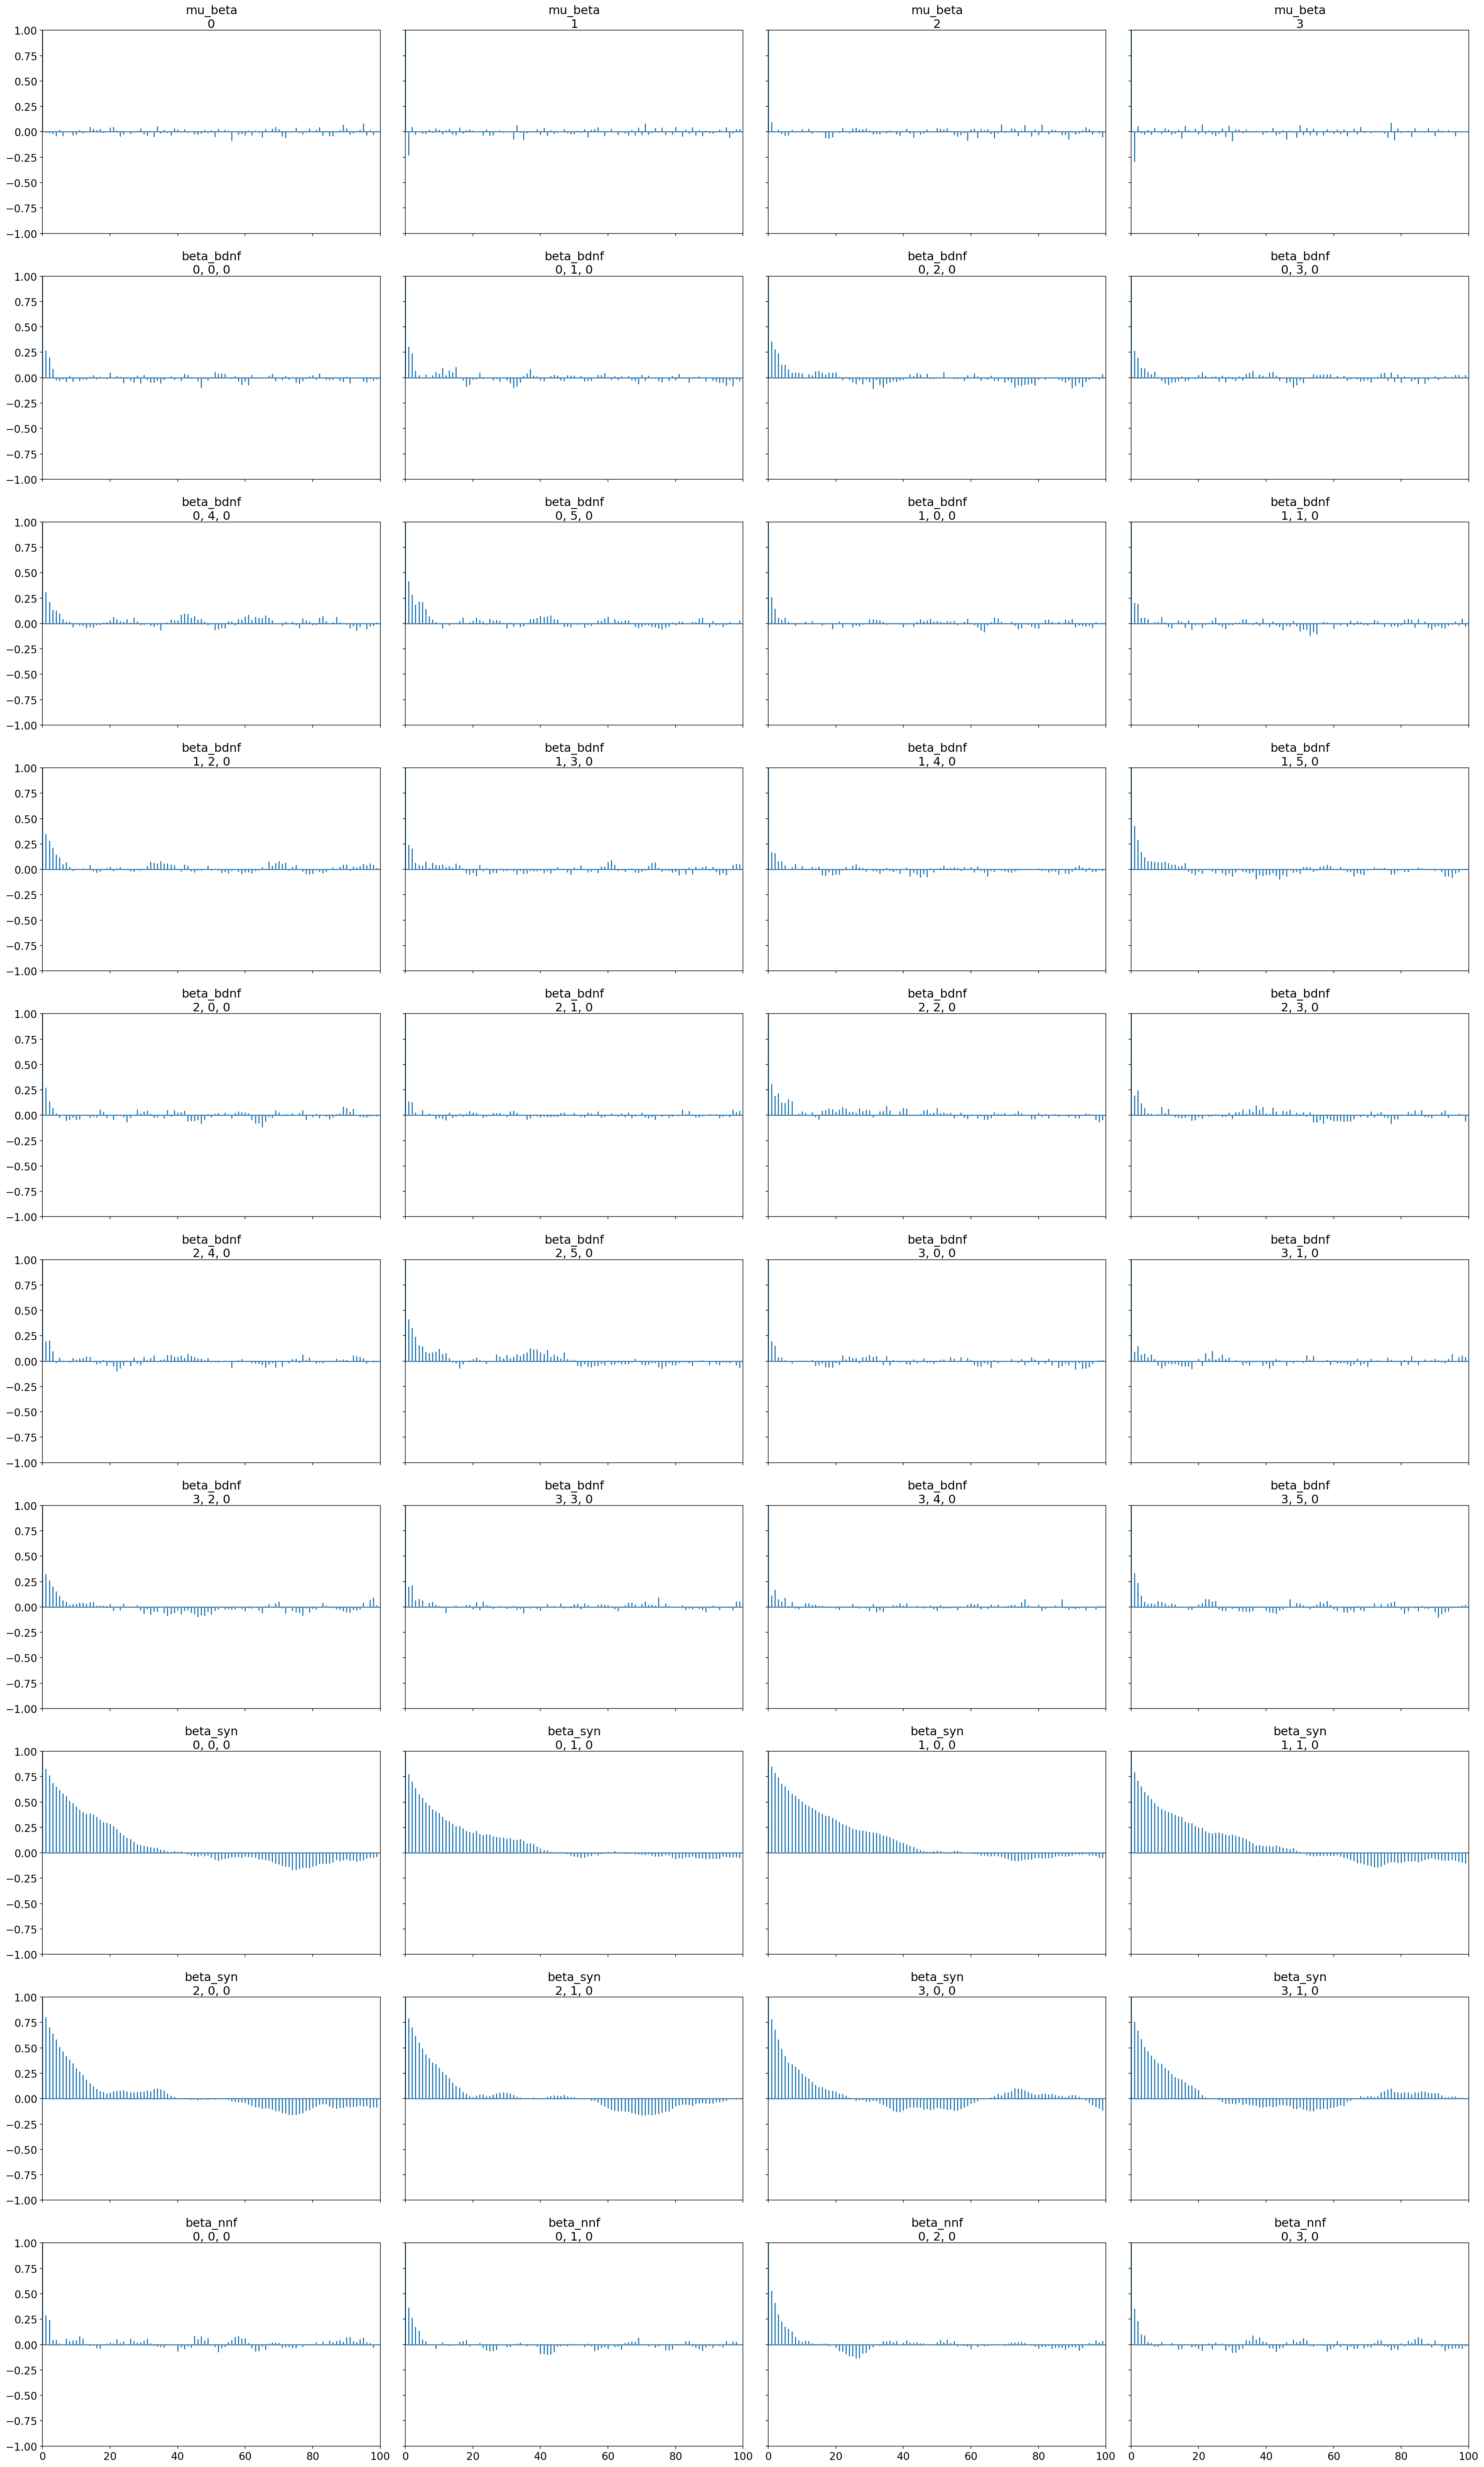

In [7]:
# --- Autocorrelation plot of the inference step --- #
pm.autocorrplot(trace_hierar);

# SYN and BDNF show correlations during the inference step, 
# which is also explained by the initial Pearson correlation plot.
# Tricky to solve this especially because we have a mix of X variables (continues and discrete)

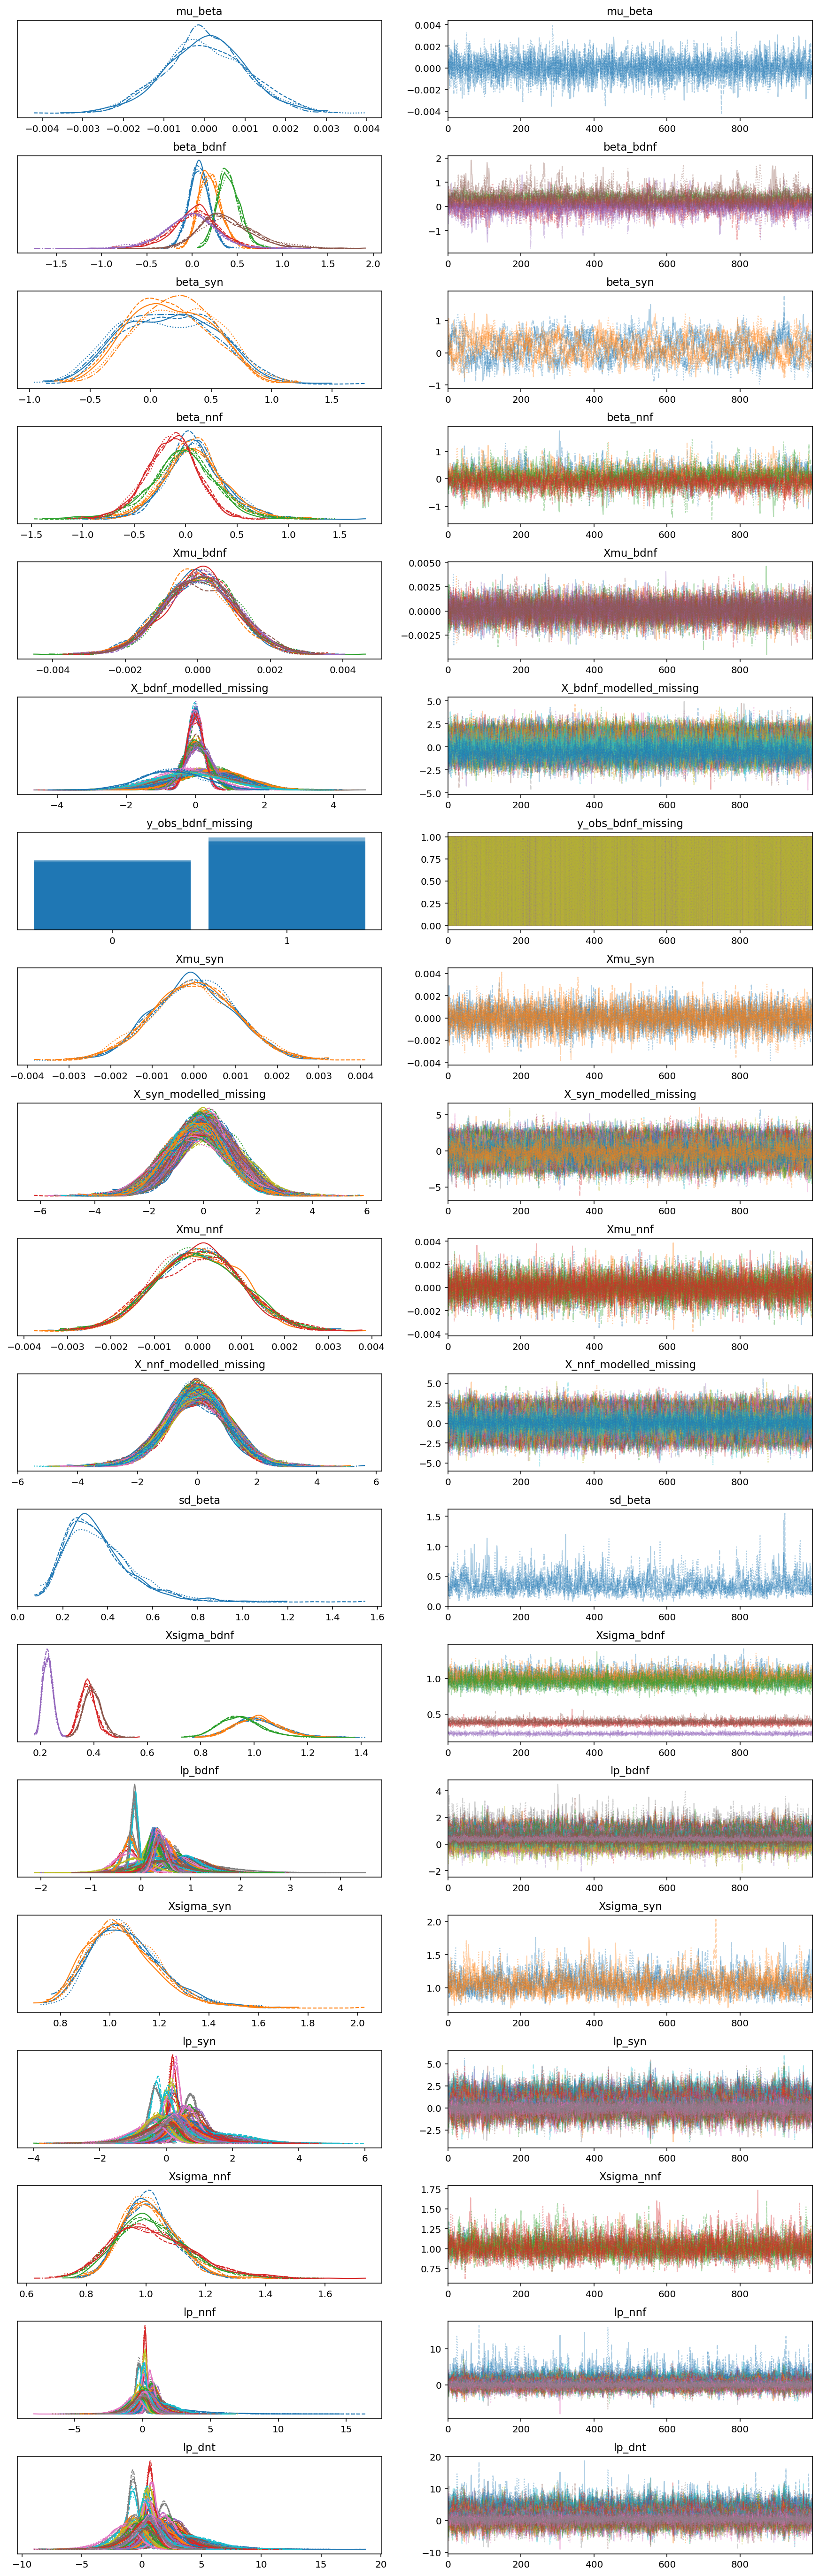

In [8]:
# --- Plot traces of all variables --- #
pm.traceplot(trace_hierar);